In [1]:
# Plotting
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_palette("bright") # I don't like the default.

# For looping but only printing each loop
from IPython.display import clear_output 

# The tomo challege package and metrics
import sys
sys.path.insert(0, '../')
import tomo_challenge as tc
from tomo_challenge.jax_metrics import compute_snr_score, compute_fom

# Built in library
import time
import json

# Jax imports, and turn on 64 bit
from jax import grad
import jax
import jax.numpy as jnp
from jax.core import UnexpectedTracerError
from jax import config
config.update("jax_enable_x64", True)

# Setting seeds for any random number generations
np.random.seed(1985)
gen = np.random.RandomState(seed=1985)

Found classifier IBandOnly
Found classifier RandomForest
Found classifier Random


In [2]:
d_loc = "../data"
x_train = pd.DataFrame.from_dict(tc.load_data(f"{d_loc}/training.hdf5", "griz", colors=True, errors=True))
z_train = tc.load_redshift(f"{d_loc}/training.hdf5")

../tomo_challenge/data.py:89: UserWarning: Setting inf (undetected) bands to mag=30
  warnings.warn("Setting inf (undetected) bands to mag=30")


In [3]:
color_data = x_train[["r", "gr", "ri", "rz"]].to_numpy()
errs = x_train[["r_err"]].to_numpy()

err_thresh = 0.01
err_cond = errs >= err_thresh
weights = np.where(errs < err_thresh, 1, 1/errs**2)
weights[err_cond] = weights[err_cond] / np.max(weights[err_cond])

In [4]:
# Make the mean zero then find the covariance matrix
# divde by len-1 because sample and not population covariance
# First line is unweighted mean, second is the weighted average.
# color_shifted = color_data - np.mean(color_data, axis=0)
color_shifted = color_data - np.average(color_data[:,0].reshape(-1, 1), weights=weights)
cov = color_shifted.T @ color_shifted / (color_shifted.shape[0] - 1)

# Find the eigen values and eigen vectors of the covariance matrix
# The eigen vectors are vertical!
# Eigen vectors are principal components of dataset
eigen_variance, eigen_matrix = np.linalg.eig(cov)

# Sorting so we make sure that the vectors are in order of importance
eigen_matrix = eigen_matrix[np.argsort(-eigen_variance)]
eigen_variance = eigen_variance[np.argsort(-eigen_variance)]

24.139006057450977
22.371130249024198


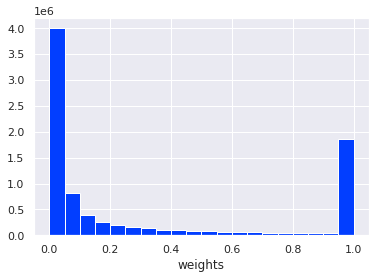

In [5]:
# plt.hist(errs[errs < 30], bins=15)
plt.hist(weights, bins=20)
plt.xlabel("weights")
# print(weights.max())
# print(weights.min())

print(np.mean(color_data[:,0]))
print(np.average(color_data[:,0].reshape(-1, 1), weights=weights))

In [6]:
def find_eigenvector(data, weights=None):
    # Start with position 1985. 1985 is the year my favourite
    # movie came out. No other reason than that. 
    phi = data[1985].reshape(1, -1)
    
    if weights is None:
        weights = np.ones_like(phi)

    thresh = 1e-6
    cond = False
    i = 0
    while not cond:
        # Find the coefficients that match the eigen vector to the data vector
        coeffs = data @ phi.T

        # Project the data along phi axis by multiplying the data by the coefficient
        proj = data * coeffs * weights

        # Sum all the projected ones to find the new eigenvector and then divide by the
        # length of the vector to reduce it to unit vector length.
        phi_new = np.sum(proj, axis=0)
        phi_new = phi_new / np.linalg.norm(phi_new)

        # If all of the dimensions changes by less than thresh then the
        # condition is set to true and the loop breaks
        cond = np.all((phi_new - phi) < thresh)

        phi = phi_new.reshape(1, -1)
        i += 1
    print("Iterations:", i + 1)
    return phi

In [7]:
eigs = []
num_eigs = 4
eigs = np.zeros((num_eigs, color_shifted.shape[1]))
temp_data = np.copy(color_shifted)
for i in range(num_eigs):
    v = find_eigenvector(temp_data, None)
    eigs[:,i] = (v)
    
    # Subtract the projections of the first eigen vector to start finding the next one.
    coeffs = temp_data @ v.T
    temp_data = temp_data - coeffs * v

print(eigs)
print(eigen_matrix)
# Closeness assertions for testing purposes.
# assert np.allclose(eigs[:,0], eigen_matrix[:,0]) or np.allclose(-eigs[:,0], eigen_matrix[:,0], atol=1e-3)
# assert np.allclose(eigs[:,1], eigen_matrix[:,1]) or np.allclose(-eigs[:,1], eigen_matrix[:,1], atol=1e-3)
# assert np.allclose(eigs[:,2], eigen_matrix[:,2]) or np.allclose(-eigs[:,2], eigen_matrix[:,2], atol=1e-3)
# assert np.allclose(eigs[:,3], eigen_matrix[:,3]) or np.allclose(-eigs[:,3], eigen_matrix[:,3], atol=1e-3)

Iterations: 4
Iterations: 11
Iterations: 8
Iterations: 3
[[ 0.0471107   0.99857377 -0.02047592  0.01455131]
 [-0.57526083  0.01125107 -0.81585551 -0.05769038]
 [-0.58179452  0.02417952  0.35897862  0.72942775]
 [-0.57303638  0.04625134  0.45287402 -0.68146551]]
[[ 0.0471107  -0.99857377 -0.0204758  -0.01455131]
 [-0.57526083 -0.01125117 -0.8158555   0.05769042]
 [-0.58179452 -0.02417947  0.35897858 -0.72942777]
 [-0.57303638 -0.04625128  0.45287406  0.68146548]]


[0.99790122 0.99964486 0.9999619  1.        ]


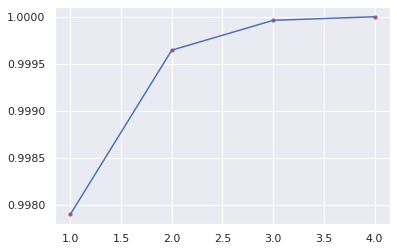

In [8]:
# Plots the amount of variance in the data explained by the number
# of principal components chosen.
x = np.arange(0, len(eigen_variance)) + 1
y = np.cumsum(eigen_variance) / np.sum(eigen_variance)

plt.plot(x, y, c="b")
plt.scatter(x, y, s=10, c="r")
print(y)

In [9]:
# The selection of principal axis vectors that will reduce dimensionality
reducer = eigs[:, 0:3]
# reducer = eigen_matrix[0:2].T
data_reduced = color_data @ reducer

# I took this cut from the random forest example.
# I cut after doing the PCA in case the cut changes the
# principal axes and I want to avoid that.
cut = np.random.uniform(0, 1, data_reduced.shape[0]) < 0.05
data_cut =  data_reduced[cut]
z_cut = z_train[cut]

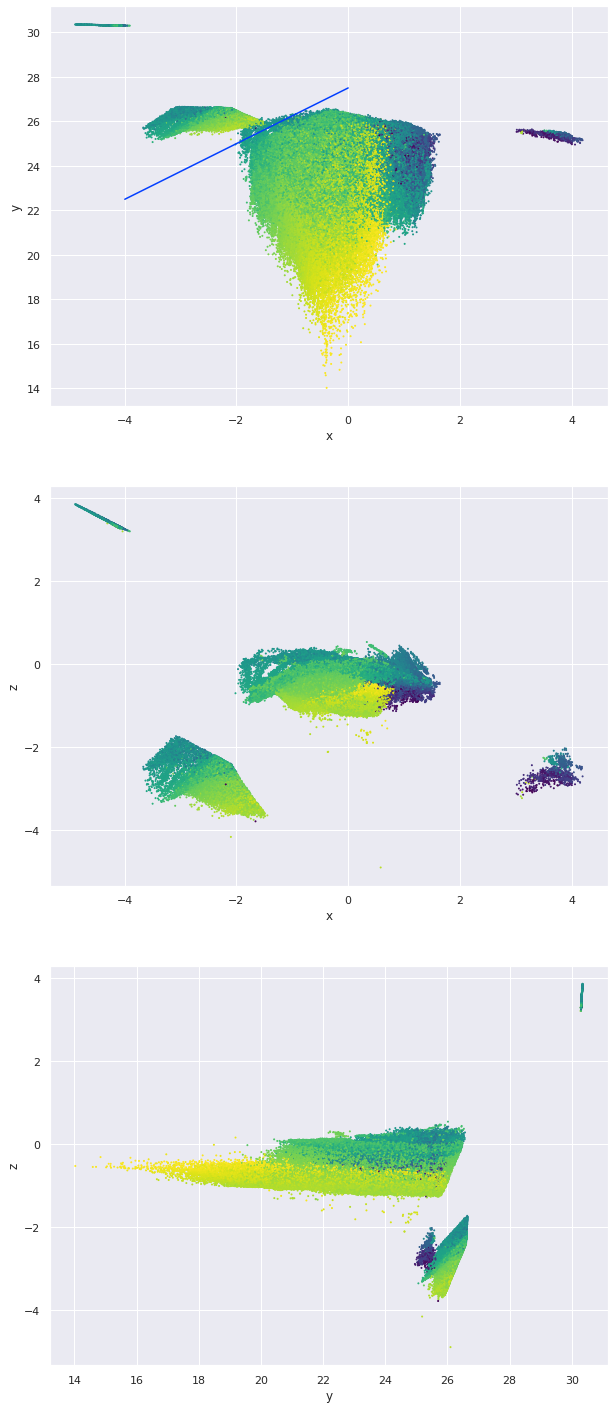

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(10, 25))

# Plotting data itself.
im = ax[0].scatter(data_cut[:, 0], data_cut[:, 1], s=1, c=z_cut, cmap="viridis_r")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

# The dividing line, is a lot more obvious on the buzzard data set.
def reg(x):
    return (x) * 5/4 + 27.5
ax[0].plot([-4, 0], reg(np.asarray([-4, 0])))

ax[1].scatter(data_cut[:, 0], data_cut[:, 2], s=1, c=z_cut, cmap="viridis_r")
ax[1].set_xlabel("x")
ax[1].set_ylabel("z")

ax[2].scatter(data_cut[:, 1], data_cut[:, 2], s=1, c=z_cut, cmap="viridis_r")
ax[2].set_xlabel("y")
ax[2].set_ylabel("z")

plt.show()

In [11]:
def get_equality_centroids(data, redshift, n_bins=3):
    # Find the edges that split the redshifts into n_bins bins of
    # equal number counts in each
    p = np.linspace(0, 100, n_bins + 1)
    z_edges = np.percentile(redshift, p)

    training_bin = np.zeros_like(data[:, 0])

    # Now find all the objects in each of these bins
    for i in range(n_bins):
        z_low = z_edges[i]
        z_high = z_edges[i + 1]
        training_bin[(redshift > z_low) & (redshift <= z_high)] = i
    
    centroids = []
    for i in range(0, int(training_bin.max()) + 1):
        cond = training_bin == i
        centroids.append(data[cond].mean(axis=0))

    return np.asarray(centroids)

In [12]:
@jax.jit
def softmax(x, beta=1):
    return jnp.exp(beta * x) / jnp.sum(jnp.exp(beta * x), axis=0)

@jax.jit
def dist(points, centroids, beta=1):
    # Finds the distance between the points and the centroids
    dist = []
    for center in centroids:
        shift = points - center
        dist.append(jnp.linalg.norm(shift, axis=1))

    # Converting to numpy array so we can use boolean indexing
    dist = jnp.asarray(dist)
    
    # Which category these would be assigned to based on their distances
    # soft min, don't have to one_hot then and the gradient should work.
    return softmax(-dist, beta).T 

@jax.jit
def dist_snr(points, centroids, z, beta=1):
    cat = dist(points, centroids, beta)
    return -compute_snr_score(cat, z, binned_nz=True)
    
@jax.jit
def dist_fom(points, centroids, z, beta=1):
    cat = dist(points, centroids, beta)
    return -compute_fom(cat, z, binned_nz=True)

In [13]:
def fit_centroids(points, redshift, num_centroids=3, num_epochs=10, impl="snr", lr=0.002):
#     ind = gen.randint(0, len(points), num_centroids)
#     # Must shift by a little so we don't get nan gradients due to 0 distances
#     centroids = points[ind].astype("float32") + (np.ones_like(points[0]) / 100)

    # Starting points
    centroids = get_equality_centroids(points, redshift, num_centroids)# - (np.ones_like(points[0]) / 100)
    beta = np.ones(1)
    snr_history = []

    d2 = dist_fom if impl == "fom" else dist_snr
    
    # Index of the thing we're improving for taking derivative
    # And the thing we're improving.
    def loop_and_improve(val, ind):
        to_improve = np.copy(val)
        
        # Total grad storing for momentum
        total_grad = np.zeros_like(to_improve)
        
        # Terminate at the number of epochs or if the change 
        # in snr is too small to be meaningful. We also force 
        # a minimum of 4 epochs.
        i = 0
        delta_snr = 1
        cur_lr = lr# if ind == 3 else 2 * lr
        while (i < num_epochs and abs(delta_snr) > 0.10) or i < 4:
            try:
                print("Epoch", i + 1)
                if ind == 3:
                    snr, grads = jax.value_and_grad(d2, ind)(points, centroids, redshift, to_improve)
                else:
                    snr, grads = jax.value_and_grad(d2, ind)(points, to_improve, redshift, beta)
                snr_history.append(-snr)
                print(f"{impl.upper()}:", -snr)  
                total_grad = grads# + 0.9 * total_grad # Momentum baby
                # 2500/(points.size) ~ 0.002
                
                # Learning rate annealing
                cur_lr *= 0.9
                
                to_improve += -(total_grad) * cur_lr

                i += 1
                if len(snr_history) > 1:
                    delta_snr = -snr - snr_history[-2]
                    print(delta_snr)
            except UnexpectedTracerError:
                print("Tracer Error, retrying epoch")
                continue
                
        return to_improve

    print("Beta loop.")
    beta = loop_and_improve(beta, 3)
    print(f"Final beta: {beta}")
    print()
    
    print("Centroids loop.")
    snr_history = []
    centroids = loop_and_improve(centroids, 1)
    
    # Restarts seem to only marginally improve the FOM
    if impl != "fom":
        print("\nRestart 1")
        # A restart
        centroids = loop_and_improve(centroids, 1)

        print("\nRestart 2")
        # A restart
        centroids = loop_and_improve(centroids, 1)
    
    # In case the final tracer escapes just run it again. 
    # Janky, but what part of Jax isn't?
    try:
        print(f"Final {impl.upper()}:", -d2(points, centroids, redshift, beta))
    except UnexpectedTracerError:
        print(f"Final {impl.upper()}:", -d2(points, centroids, redshift, beta))
        
    print(f"Final beta: {beta}")
    plt.plot(np.arange(0, len(snr_history)) + 1, snr_history, label=num_centroids)
    return centroids

@jax.jit
def classify(points, centroids):
    # Finds the distance between the points and the centroids
    dist = []
    for center in centroids:
        shift = points - center
        dist.append(jnp.linalg.norm(shift, axis=1))

    # Converting to numpy array so we can use boolean indexing
    dist = jnp.asarray(dist)

    # Which category these would be assigned to based on their distances
    return jnp.argmin(dist, axis=0)

Beta loop.
Epoch 1


/global/homes/d/dylang/.conda/envs/tomo-jax/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


SNR: 720.1315718819611
Epoch 2
SNR: 745.8208669133005
25.689295031339384
Epoch 3
SNR: 766.2558915712224
20.435024657921872
Epoch 4
SNR: 780.7705884418808
14.51469687065844
Epoch 5
SNR: 791.0505008753945
10.279912433513687
Epoch 6
SNR: 798.5374964193508
7.4869955439562546
Epoch 7
SNR: 804.1622867029101
5.624790283559378
Epoch 8
SNR: 808.5056038539801
4.343317151069982
Epoch 9
SNR: 811.9372423788543
3.431638524874188
Epoch 10
SNR: 814.7004262397625
2.763183860908157
Epoch 11
SNR: 816.9604878132941
2.2600615735316296
Epoch 12
SNR: 818.8332691435893
1.8727813302951972
Epoch 13
SNR: 820.4021550568626
1.5688859132733342
Epoch 14
SNR: 821.7286104211394
1.3264553642767396
Epoch 15
SNR: 822.858899146191
1.1302887250516278
Epoch 16
SNR: 823.8284906229386
0.9695914767476097
Epoch 17
SNR: 824.6650245081744
0.8365338852357809
Epoch 18
SNR: 825.3903522850756
0.7253277769011675
Epoch 19
SNR: 826.0219728312848
0.6316205462092057
Epoch 20
SNR: 826.5740611701634
0.5520883388786615
Epoch 21
SNR: 827.0582

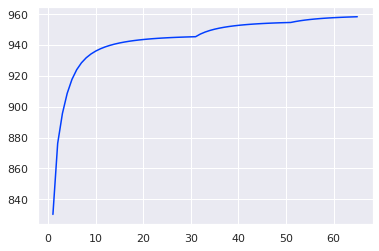

In [14]:
t0 = time.perf_counter()
centers = fit_centroids(data_cut, z_cut, num_centroids=3, num_epochs=70, impl="snr", lr=0.004)
duration = time.perf_counter() - t0
print(f"Trained in {duration} seconds")

Text(0, 0.5, 'y')

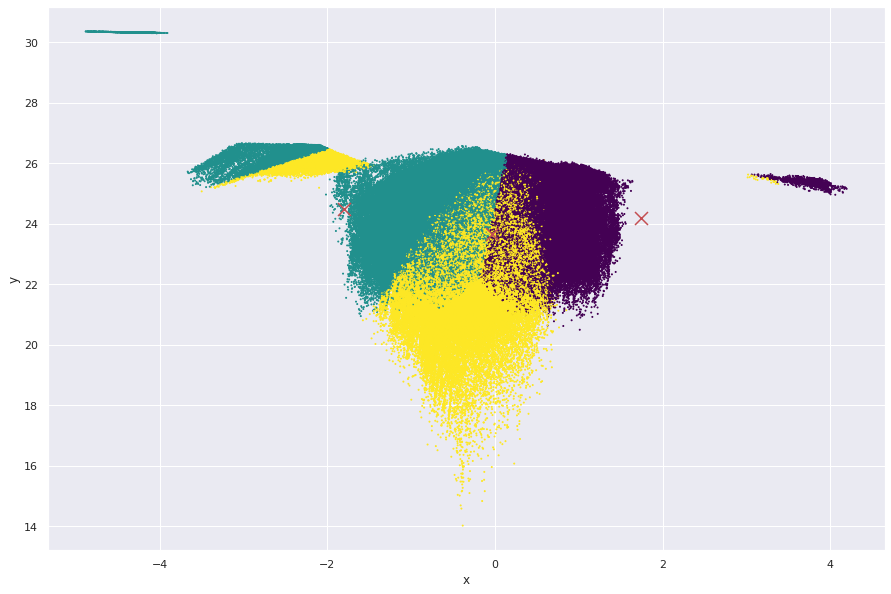

In [15]:
fig, ax = plt.subplots(figsize=(15, 10))

y_train = classify(data_cut, centers)

# Plotting data itself.
ax.scatter(data_cut[:, 0], data_cut[:, 1], s=1, c=y_train, cmap="viridis_r")
ax.scatter(centers[:, 0], centers[:, 1], marker='x', s=169, linewidths=3,
            color='r', zorder=10)
ax.set_xlabel("x")
ax.set_ylabel("y")

Classified all points in 0.24752198497299105 seconds


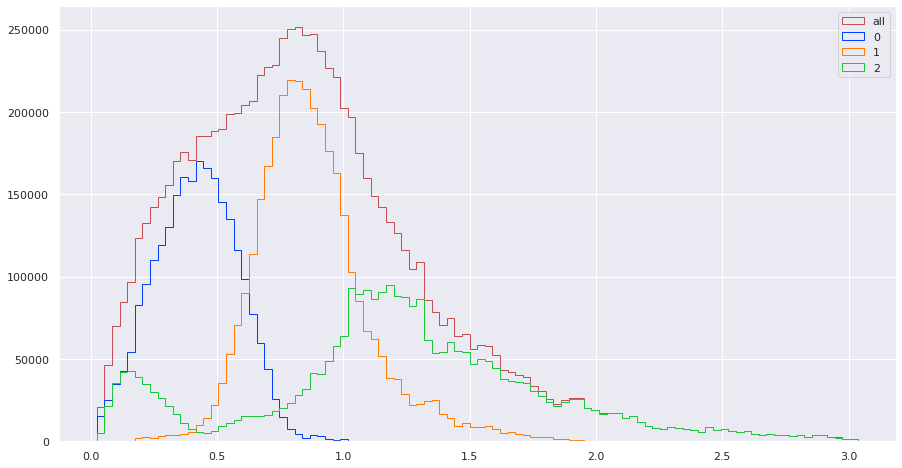

In [16]:
# Predict the categories of the full and uncut dataset and then make a histogram
# Once we have the individual group histograms I additionally plot a
# histogram of the entire dataset to verify it adds up.
t0 = time.perf_counter()
y_train = classify(data_reduced, centers)

print(f"Classified all points in {time.perf_counter() - t0} seconds")

fig, ax = plt.subplots(figsize=(15, 8))
_, bins, _ = plt.hist(z_train, bins=100, histtype="step", color="r", label="all")

for i in range(0, int(y_train.max()) + 1):
    plt.hist(z_train[y_train == i], bins=bins, histtype="step", label=i)
plt.legend()
plt.show()

In [17]:
x_valid = pd.DataFrame.from_dict(tc.load_data(f"{d_loc}/validation.hdf5", "griz", colors=True))
z_valid = tc.load_redshift(f"{d_loc}/validation.hdf5")

data_valid = x_valid[["r", "gr", "ri", "rz"]].to_numpy()
data_valid_r = data_valid @ reducer

Classified all points in 0.5639187739579938 seconds


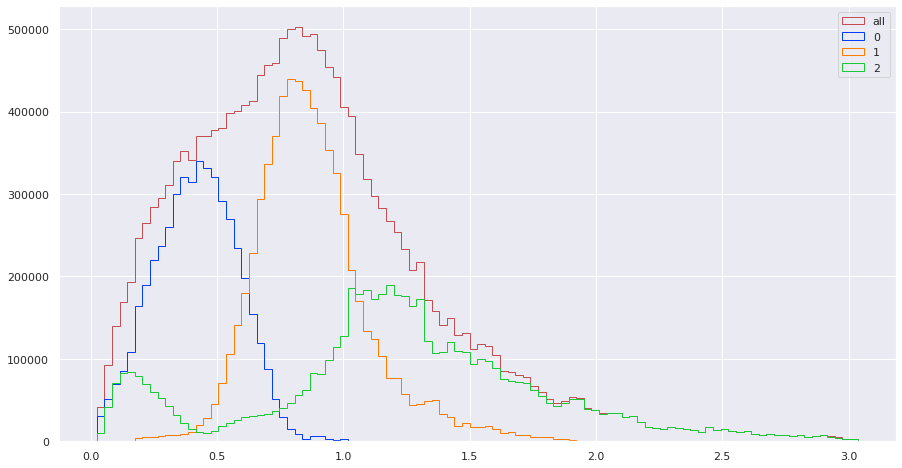

In [18]:
# Predict the categories of the full and uncut dataset and then make a histogram
# Once we have the individual group histograms I additionally plot a
# histogram of the entire dataset to verify it adds up.
t0 = time.perf_counter()
valid_cond = data_valid_r[:, 1] < reg(data_valid_r[:, 0])
# y_valid = total_classify(data_valid_r, lower_centers, upper_aligned, valid_cond)

y_valid = classify(data_valid_r, centers)

print(f"Classified all points in {time.perf_counter() - t0} seconds")

fig, ax = plt.subplots(figsize=(15, 8))
_, bins, _ = plt.hist(z_valid, bins=100, histtype="step", color="r", label="all")

for i in range(0, int(y_valid.max()) + 1):
    plt.hist(z_valid[y_valid == i], bins=bins, histtype="step", label=i)
plt.legend()
plt.show()

In [19]:
# Compute those scores.
print(f"Computing the scores for {y_valid.max() + 1} bins.")
t0 = time.perf_counter()
scores = tc.jc_compute_scores(y_valid, z_valid, 
                              metrics=["SNR_ww", "SNR_gg", "SNR_3x2", "FOM_ww", "FOM_gg", "FOM_3x2"])
duration = time.perf_counter() - t0
print(f"{scores} in {duration} seconds")

Computing the scores for 3 bins.
{'SNR_ww': 345.8642349006271, 'FOM_ww': 18.06464145958825, 'SNR_gg': 1020.8426170201263, 'FOM_gg': 271.72791652075904, 'SNR_3x2': 1025.2466390592851, 'FOM_3x2': 1391.1243958061536} in 253.54744301002938 seconds


In [17]:
with open("score_hist.json", "r") as f:
    score_hist_jc = json.load(f)

Classifying 8 bins.
Beta loop.
Epoch 1
SNR: 728.2444419024306
Epoch 2
SNR: 755.4096179383662
27.165176035935588
Epoch 3
SNR: 778.3238480221364
22.914230083770235
Epoch 4
SNR: 795.8233573840815
17.499509361945115
Epoch 5
SNR: 851.2690934066745
2.484538168307381
Epoch 14
SNR: 853.3954034183508
2.12631001167631
Epoch 15
SNR: 855.2266941124534
1.831290694102563
Epoch 16
SNR: 856.8124565699096
1.5857624574562124
Epoch 17
SNR: 858.1920085181071
1.3795519481974452
Epoch 18
SNR: 859.3969916645929
1.2049831464858016
Epoch 19
SNR: 860.4531646968913
1.0561730322984886
Epoch 20
SNR: 861.3817130434524
0.9285483465610014
Epoch 21
SNR: 862.2002209335244
0.8185078900720555
Epoch 22
SNR: 862.9234034088663
0.7231824753419005
Epoch 23
SNR: 863.5636649953396
0.6402615864733434
Epoch 24
SNR: 864.1315313713461
0.5678663760064637
Epoch 25
SNR: 864.6359867230625
0.5044553517163877
Epoch 26
SNR: 865.0847401838129
0.4487534607503676
Epoch 27
SNR: 865.4844383294105
0.3996981455976538
Epoch 28
SNR: 865.8408361950

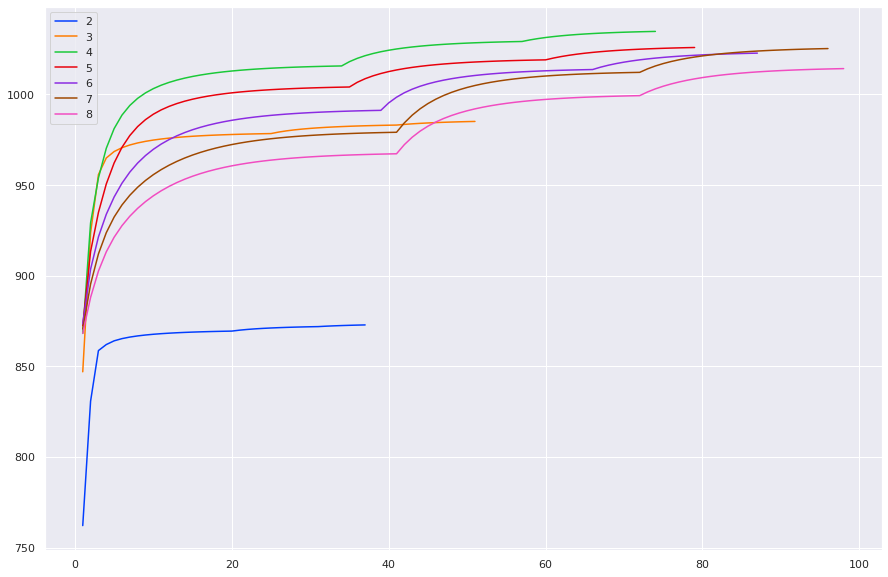

In [28]:
# Compute those scores.
score_hist_jc = []

fig, ax = plt.subplots(figsize=(15, 10))

z_cut = z_train[cut]
for j in range(2, 9):
    clear_output(wait=True)
    print(f"Classifying {j} bins.")
    
    t0 = time.perf_counter()
    lr = 0.024 / j
    centers = fit_centroids(data_cut, z_cut, num_centroids=j, num_epochs=70, impl="snr", lr=lr)
    duration = time.perf_counter() - t0
    print(f"Trained in {duration} seconds")

    y_valid = classify(data_valid_r, centers)
    
    print(f"Computing scores for {j} bins.")
    try:
        score_hist_jc.append(tc.jc_compute_scores(y_valid, z_valid, metrics=["SNR_ww", "SNR_gg", "SNR_3x2", 
                                                                             "FOM_ww", "FOM_gg", "FOM_3x2"]))
    except UnexpectedTracerError:
        score_hist_jc.append(tc.jc_compute_scores(y_valid, z_valid, metrics=["SNR_ww", "SNR_gg", "SNR_3x2", 
                                                                             "FOM_ww", "FOM_gg", "FOM_3x2"]))
plt.legend()
plt.show()

In [31]:
# Look sometimes I don't want to wait 3 hours for this data to regenerate.
with open("score_hist_snr.json", "w") as f:
    json.dump(score_hist_jc, f)

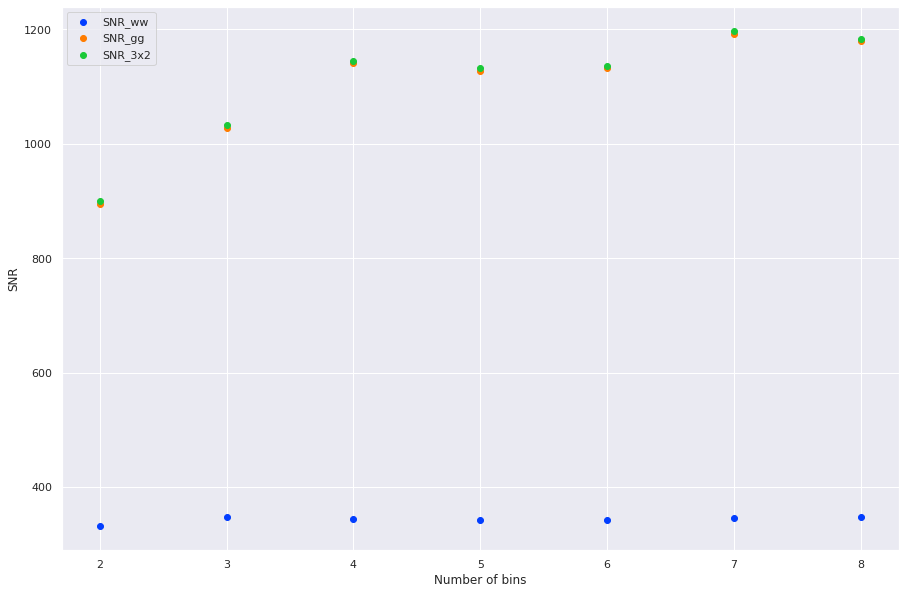

In [32]:
metric = "SNR"
x_hist = np.arange(2, len(score_hist_jc) + 2)
snr_gg = np.asarray([x[f"{metric}_gg"] for x in score_hist_jc])
snr_ww = np.asarray([x[f"{metric}_ww"] for x in score_hist_jc])
snr_32 = np.asarray([x[f"{metric}_3x2"] for x in score_hist_jc])

fig, ax = plt.subplots(figsize=(15, 10))

plt.scatter(x_hist, snr_ww[x_hist - 2], label=f"{metric}_ww")
plt.scatter(x_hist, snr_gg[x_hist - 2], label=f"{metric}_gg")
plt.scatter(x_hist, snr_32[x_hist - 2], label=f"{metric}_3x2")
plt.xlabel("Number of bins")
plt.ylabel(metric)
plt.legend()
plt.savefig("hist.png")

In [21]:
from sklearn.ensemble import RandomForestClassifier

color_cut = color_data[cut]
score_hist_forest = []

for j in range(2, 9):
    clear_output(wait=True)
    print(f"Generating {j} true bins.")
    
    # Find the edges that split the redshifts into n_z bins of
    # equal number counts in each
    p = np.linspace(0, 100, j + 1)
    z_edges = np.percentile(z_train, p)

    training_bin = np.zeros_like(data_reduced[:, 0])

    # Now find all the objects in each of these bins
    for i in range(j):
        z_low = z_edges[i]
        z_high = z_edges[i + 1]
        training_bin[(z_train > z_low) & (z_train <= z_high)] = i
    
    print(f"Classifying {j} bins.")
    
    temp_classifier = RandomForestClassifier()

    # The y to predict is the bin number, the x input is the (2-d) data
    t0 = time.perf_counter()
    temp_classifier.fit(color_cut, training_bin[cut])
    duration = time.perf_counter() - t0
    print(f"Trained in {duration} seconds")
    
    # Slow. That's why my method is better. 
    y_valid = temp_classifier.predict(data_valid)
    
    print(f"Computing scores for {j} bins.")
    try:
        score_hist_forest.append(tc.jc_compute_scores(y_valid, z_valid, metrics=["SNR_ww", "SNR_gg", "SNR_3x2", 
                                                                             "FOM_ww", "FOM_gg", "FOM_3x2"]))
    except UnexpectedTracerError:
        score_hist_forest.append(tc.jc_compute_scores(y_valid, z_valid, metrics=["SNR_ww", "SNR_gg", "SNR_3x2", 
                                                                             "FOM_ww", "FOM_gg", "FOM_3x2"]))

In [22]:
# Since this shouldn't change this is useful.
with open("score_forest.json", "w") as f:
    json.dump(score_hist_forest, f)

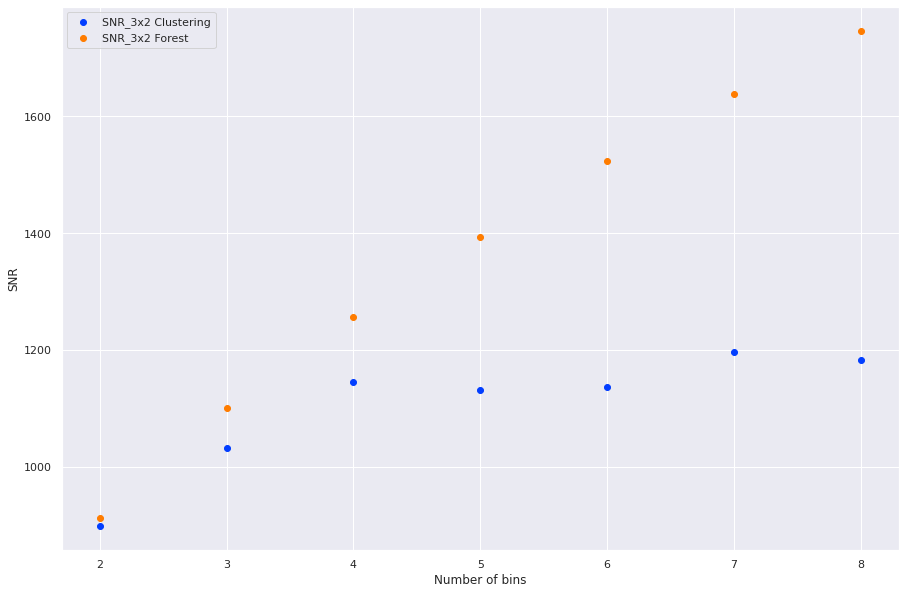

In [35]:
metric = "SNR"
x_hist = np.arange(2, len(score_hist_jc) + 2)
score_cluster = np.asarray([x[f"{metric}_3x2"] for x in score_hist_jc])
score_forest = np.asarray([x[f"{metric}_3x2"] for x in score_hist_forest])

fig, ax = plt.subplots(figsize=(15, 10))

plt.scatter(x_hist, score_cluster[x_hist - 2], label=f"{metric}_3x2 Clustering")
plt.scatter(x_hist, score_forest[x_hist - 2], label=f"{metric}_3x2 Forest")
plt.xlabel("Number of bins")
plt.ylabel(metric)
plt.legend()
plt.savefig("hist-comparison.png")

# TESTING
Below here I tested using Newton's Method rather than Gradient Descent to train, but it is not any better.

In [112]:
num_c = 3
centroids = get_equality_centroids(data_cut, z_cut, num_c)

f = lambda beta: -dist_snr(data_cut, centroids, z_cut, beta)

def hessian(f):
    return jax.jacfwd(jax.jacrev(f))

test_beta = 2.0
gamma = 1
for i in range(0, 10):
    J = jax.jacfwd(f)(test_beta)
    H = hessian(f)(test_beta)

    test_beta -= J/H * gamma
    print(test_beta)
    print(f(test_beta))
    print()
    
print(test_beta)

3.4596969253895775
843.5894444644534

4.757893730823728
858.8741250109208

6.155238340434289
865.1503775758027

7.680659299462709
867.7774212405225

9.291819698089245
868.8221050802949

10.862885265663895
869.1892800777358

12.161894298476644
869.2889886634633

12.917823612582561
869.3044949519792

13.126161997018983
869.3052111242383

13.139227680481747
869.305213547123

13.139227680481747


In [117]:
# test_beta = 5
gamma = 0.1
centroids = get_equality_centroids(data_cut, z_cut, num_c)
f2 = lambda cent: -dist_snr(data_cut, cent, z_cut, test_beta)

print(centroids)
print(f2(centroids))

for i in range(0, 10):
    J = jax.jacfwd(f2)(centroids)
    H = hessian(f2)(centroids)
    
    t1 = np.linalg.inv(H.reshape(3 * num_c, -1))
    t2 = t1 @ J.reshape(-1)
    t2 = t2.reshape(num_c, 3)
    
    centroids -= t2 * gamma
    print(centroids)
    print(f2(centroids))
    print()

[[-0.20357253 23.34932409 -0.90337703]
 [-0.6530622  24.39893877 -0.4471294 ]
 [ 0.20496743 24.76682828 -0.30527785]]
869.305213547123
[[-0.09375727 23.13004308 -1.03638551]
 [-0.64954295 24.34611847 -0.47973624]
 [ 0.36316715 24.79564212 -0.30609877]]
880.6081046836684

[[-0.04444477 23.00792914 -1.15244597]
 [-0.68843766 24.38465756 -0.49706953]
 [ 0.43799293 24.89212394 -0.29777529]]
885.6767170202814

[[-0.08387486 22.91801341 -1.24144206]
 [-0.76321268 24.45313176 -0.48003015]
 [ 0.51479892 25.0290316  -0.24466226]]
888.9785659284576

[[-0.04577817 22.83199214 -1.32039444]
 [-0.82582278 24.51395191 -0.49011358]
 [ 0.56248381 25.14453255 -0.24112853]]
890.7209454595886

[[ 9.47534773e-03  2.27541057e+01 -1.38991034e+00]
 [-8.90595729e-01  2.45822236e+01 -5.05445694e-01]
 [ 5.99105202e-01  2.52629237e+01 -2.51980365e-01]]
891.620037685257

[[ 0.06995774 22.67592568 -1.46595962]
 [-0.96211551 24.66191917 -0.52570004]
 [ 0.62579726 25.39013904 -0.27213114]]
892.106690716172

[[ 0.1345

Text(0, 0.5, 'y')

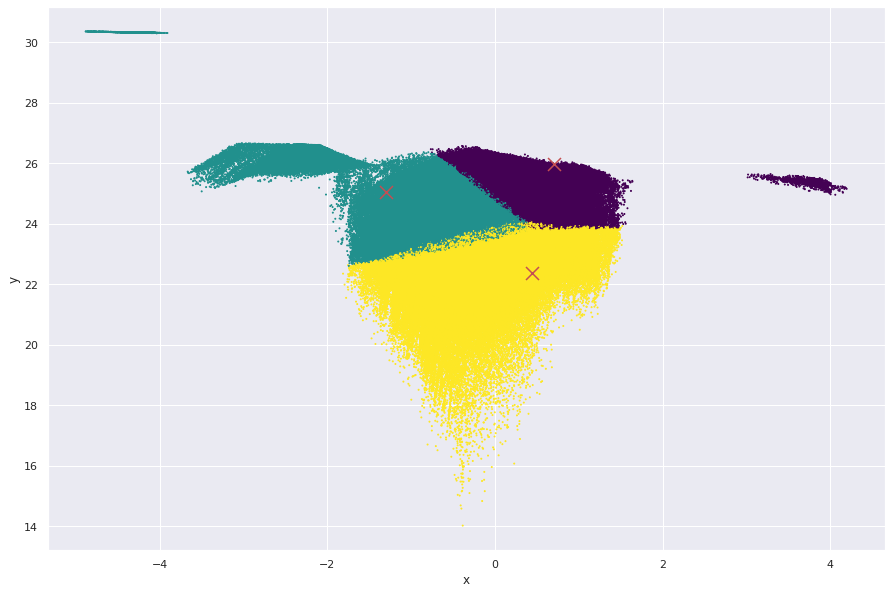

In [118]:
fig, ax = plt.subplots(figsize=(15, 10))

y_train = classify(data_cut, centroids)

# Plotting data itself.
ax.scatter(data_cut[:, 0], data_cut[:, 1], s=1, c=y_train, cmap="viridis_r")
ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3,
            color='r', zorder=10)
ax.set_xlabel("x")
ax.set_ylabel("y")

In [119]:
y_valid = classify(data_valid_r, centroids)
# Compute those scores.
print(f"Computing the scores for {y_valid.max() + 1} bins.")
t0 = time.perf_counter()
scores = tc.jc_compute_scores(y_valid, z_valid, 
                              metrics=["SNR_ww", "SNR_gg", "SNR_3x2", "FOM_ww", "FOM_gg", "FOM_3x2"])
duration = time.perf_counter() - t0
print(f"{scores} in {duration} seconds")

Computing the scores for 3 bins.
{'SNR_ww': 330.22735434352836, 'FOM_ww': 7.379722590770253, 'SNR_gg': 885.8803963896958, 'FOM_gg': 269.73700255705603, 'SNR_3x2': 895.446660617346, 'FOM_3x2': 853.7733353247885} in 190.14394263799477 seconds


In [84]:
# test_beta = 1
num_c = 2
centroids = get_equality_centroids(data_cut, z_cut, num_c)
f2 = lambda cent: -dist_snr(data_cut, cent, z_cut, test_beta)

print(centroids.shape)
print(f2(centroids))

J = jax.jacfwd(f2)(centroids)
H = hessian(f2)(centroids)
print(H)
print(H.shape)
print(J)
print(J.shape)

t1 = np.linalg.inv(H.reshape(3 * num_c, -1))
t2 = t1 @ J.reshape(-1)
print(t2)
print(t2.shape)

t2 = t2.reshape(num_c, 3)
print(t2)

print(centroids)
print(centroids - t2)
print(f2(centroids - t2))

(2, 3)
701.5199047636938
[[[[ 15.96374773  -3.91608153 -11.36982649]
   [-27.69067534   4.96927496   4.18079109]]

  [[ -3.91608153  -6.49539599  -1.55363946]
   [  7.86521547   5.12466864  -2.86905503]]

  [[-11.36982649  -1.55363946 -10.82528726]
   [  7.5122007   -3.78881108 -16.69210712]]]


 [[[-27.69067534   7.86521547   7.5122007 ]
   [ 28.40349952  -7.71103808   0.20669721]]

  [[  4.96927496   5.12466864  -3.78881108]
   [ -7.71103808 -16.24426458  -0.64471472]]

  [[  4.18079109  -2.86905503 -16.69210712]
   [  0.20669721  -0.64471472 -10.90264755]]]]
(2, 3, 2, 3)
[[ 11.69832548 -31.9091892  -34.71528596]
 [ -9.41188821  29.76460545  39.66204282]]
(2, 3)
[ 4.31697048  6.95895266 -4.01942193  3.26220554  0.97957945  2.34402255]
(6,)
[[ 4.31697048  6.95895266 -4.01942193]
 [ 3.26220554  0.97957945  2.34402255]]
[[-0.35510005 23.63822464 -0.78901134]
 [-0.07934476 24.70516564 -0.31484647]]
[[-4.67207053 16.67927197  3.23041059]
 [-3.34155029 23.7255862  -2.65886903]]
692.3726072